In [31]:
#importing required packages 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor, ElasticNet, BayesianRidge
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
import time
from xgboost import XGBRegressor

In [ ]:
#loading the data and setting my features and target variables in the training data 
trainh = pd.read_csv('train (1).csv', sep=',')
testh = pd.read_csv('test (1).csv', sep=',')
features, target = trainh.iloc[:,:-1], trainh.iloc[:,-1]
combineddf = pd.concat([trainh, testh], axis = 0)
combineddf.index = list(range(0,2919))
combineddf

In [ ]:
#using our previously created PreProcess function to preprocess our data to subsequently start tuning and stacking
def PreProcess(combineddf):
    """
    #Keyword Arguments
    -----------------
    **Inputs**
    combineddf -- your dataframe combining training and test sets. See repository for .csv file 
    
    **Outputs**
    finaltrain -- your cleaned training dataset in .csv format 
    finaltest -- your cleaned testing dataset in .csv format
    """
    
    #splitting the combineddf into training and test sets 
    traindf = combineddf.iloc[:1460, :]
    testdf = combineddf.iloc[1460:, :]
    
    #removing GrLivArea outliers in the traindf dataset
    traindf = traindf.drop(traindf[(traindf.GrLivArea > 4500)].index)
    
    #removing LotFrontage outliers in the training dataset
    traindf = traindf.drop(traindf[(traindf.LotFrontage > 300)].index)
    
    #storing SalePrice from the training dataset as pandas Series
    global target
    target = traindf.SalePrice
    #dropping SalePrice from the training and testing datasets
    traindf = traindf.drop(['SalePrice'], axis = 1)
    testdf = testdf.drop(['SalePrice'], axis = 1)

    #concatenating training and testing datasets back together 
    fulldf = pd.concat([traindf, testdf], sort = False)  

    
    """
    
    **Imputing / Dropping variables with NA values**
    
    """
    
    #given that RL is by far the most common value in the data set with 77% of values, we can fill in missing values as RL 
    fulldf['MSZoning'] = fulldf['MSZoning'].fillna('RL')
    
    #replacing missing LotFrontage values with the mean values for each Neighborhood
    fulldf['LotFrontage'] = fulldf.groupby('Neighborhood').LotFrontage.transform(lambda x: x.fillna(x.mean())).astype(int)
    
    #NA means no alley access, so making Alley binary variable with 0 = No Alley access and 1 = Alley Access 
    fulldf['Alley'] = fulldf['Alley'].fillna('NoAlley')
    fulldf['Alley'] = fulldf['Alley'].replace({'NoAlley':0,'Grvl':1,'Pave':1})
    
    #Condition2 is 99% Norm, therefore drop
    fulldf = fulldf.drop(['Condition2'], axis = 1)
    
    #given 99% of values in Utilities are AllPub, this doesn't add much information and should therefore be dropped
    fulldf = fulldf.drop(["Utilities"], axis = 1)
    
    #filling in missing GarageYrBlt values with the same values as year built
    fulldf['GarageYrBlt'] = fulldf['GarageYrBlt'].fillna(fulldf['YearBuilt'])
    
    #dropping RoofMatl as 98% of values in full dataset are CompShg
    fulldf = fulldf.drop(['RoofMatl'], axis = 1)
    
    #imputing the one NA in both Exterior1st and Exterior2nd with the mode of each 
    fulldf['Exterior1st'] = fulldf['Exterior1st'].fillna(fulldf['Exterior1st'].mode()[0])
    fulldf['Exterior2nd'] = fulldf['Exterior2nd'].fillna(fulldf['Exterior2nd'].mode()[0])
    
    #assuming Masonry Veneer missing values mean none and imputing as None for Type and 0 for Area 
    fulldf['MasVnrType'] = fulldf['MasVnrType'].fillna('None')
    fulldf['MasVnrArea'] = fulldf['MasVnrArea'].fillna(0)
    
    #basement variables with NA mean no basement, replace with None 
    for x in ['BsmtQual', 'BsmtFinType1', 'BsmtFinType2', 'BsmtCond', 'BsmtExposure']:
        fulldf[x] = fulldf[x].fillna('None')
        
    #imputing the one missing values in BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, variables as 0, likely means no basement 
    fulldf['BsmtFinSF1'] = fulldf['BsmtFinSF1'].fillna(0)
    fulldf['BsmtFinSF2'] = fulldf['BsmtFinSF2'].fillna(0)
    fulldf['BsmtUnfSF'] = fulldf['BsmtUnfSF'].fillna(0)
    fulldf['TotalBsmtSF'] = fulldf['TotalBsmtSF'].fillna(0)
    
    #imputing missing value in the Electrical column as the mode
    fulldf['Electrical'] = fulldf['Electrical'].fillna(fulldf['Electrical'].mode()[0])
    
    #dropping LowQualFinSF variable given 99% of values are 0
    fulldf = fulldf.drop(['LowQualFinSF'], axis = 1)
    
    #imputing BsmtHalfBath and BsmtFullBath NA's as 0 
    for x in ['BsmtHalfBath','BsmtFullBath']:
        fulldf[x] = fulldf[x].fillna(0)
        
    #imputing the one missing value in KitchenQual as the mode
    fulldf['KitchenQual'] = fulldf['KitchenQual'].fillna(fulldf.KitchenQual.mode()[0])
    
    #imputing the two missing values in Functional as the mode
    fulldf['Functional'] = fulldf['Functional'].fillna(fulldf.Functional.mode()[0])
    
    #imputing NA values as Nonee in FireplaceQual variable 
    fulldf['FireplaceQu'] = fulldf['FireplaceQu'].fillna('None')
    
    #filling in the NA values as 'None' for GarageType, GarageFinish and GarageQual
    fulldf['GarageType'] = fulldf['GarageType'].fillna('None')
    fulldf['GarageFinish'] = fulldf['GarageFinish'].fillna('None')
    fulldf['GarageQual'] = fulldf['GarageQual'].fillna('None')

    #filling in missing GarageCars and GarageArea values as 0 
    fulldf['GarageCars'] = fulldf['GarageCars'].fillna(0)
    fulldf['GarageArea'] = fulldf['GarageArea'].fillna(0)

    #filling in missing GarageCond values as 0 
    fulldf['GarageCond'] = fulldf['GarageCond'].fillna('None')
    
    #filling in missing PoolQC values as 0 as NA = 'None' per documentation
    fulldf['PoolQC'] = fulldf['PoolQC'].fillna('None')
    
    #filling in missing Fence values as 0 as NA = 'None' per documentation
    fulldf['Fence'] = fulldf['Fence'].fillna('None')
    
    #dropping MiscVal column
    fulldf = fulldf.drop(['MiscVal'], axis = 1)
    
    #imputing the one missing value in SaleType as the mode
    fulldf['SaleType'] = fulldf['SaleType'].fillna(fulldf.SaleType.mode()[0])

    
    """
    
    **Dummifying qualitative variables**
    
    """
    
    #creating new variable Is_Newer_SubClss capturing age using the MSSubClass variable 
    fulldf['Is_Newer_SubClass'] = fulldf['MSSubClass'].replace({20:1, 30:0, 40:0, 45:0, 50:0, 60:1, 70:0, 75:0, 80:0, 85:0, 90:0, 120:1, 150:0, 160:1, 180:0, 190:0})
        
    #converting MSSubClass variable to string for dummification later one 
    fulldf['MSSubClass'] = fulldf['MSSubClass'].astype(str)
    
    fulldf['LotShape'] = fulldf['LotShape'].replace({'Reg': 1, 'IR1': 0, 'IR2':0, 'IR3':0})
    
    #given 95% of LandSlope variables are for 'Gentle' slope, create 0/1 dummy variable for gentle vs non-gentle slopes
    fulldf['Is_Slope_Gentle'] = (fulldf["LandSlope"] == "Gtl") * 1
    fulldf = fulldf.drop(['LandSlope'], axis = 1)
    
    #creating a TotalArea variable based on other square footage variables in dataset 
    property_area_cols = ['LotArea','TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
    fulldf["TotalArea"] = fulldf[property_area_cols].sum(axis=1)
    
    #creating a proximity to railroad variable from Condition1 values
    railroad_list = ['RRNn', 'RRAn', 'RRNe', 'RRAe']
    fulldf['RR_Proximity'] = fulldf['Condition1'].apply(lambda x: 1 if x in railroad_list else 0)
    
    #creating new age variable to capture age of house at the time it was sold 
    fulldf['Age'] = fulldf['YrSold'] - fulldf['YearBuilt']
    
    #creating dummy variable to capture if a house was sold in the year it was built 
    fulldf['YearSoldYearBuilt'] = (fulldf['YearBuilt'] == fulldf['YrSold']) * 1
    
    #creating variable of square of year built
    fulldf['SqYearBuilt'] = fulldf['YearBuilt'] ** 2
    
    #creating a variable capturing a remodeling 
    fulldf['Remodeled'] = (fulldf['YearBuilt'] != fulldf['YearRemodAdd']) * 1
    
    #creating binary variable == 1 if YearRemodAdd == YrSold
    fulldf["RecentRemodel"] = (fulldf["YearRemodAdd"] == fulldf["YrSold"]) * 1

    #creating continuous variable YearsSinceRemodel capturing difference between YrSold and YearRemodAdd
    fulldf["YearsSinceRemodel"] = fulldf["YrSold"] - fulldf["YearRemodAdd"]
    
    #transforming ExterQual variable to take on ints for qualitative values 
    qual_dict_ext = {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
    fulldf['ExterQual'] = fulldf['ExterQual'].replace(qual_dict_ext)
    fulldf['ExterCond'] = fulldf['ExterCond'].replace(qual_dict_ext)
    
    #transforming BsmtQual and BsmtCond variables to take on ints for qualitative values 
    qual_dict1 = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
    fulldf['BsmtQual'] = fulldf['BsmtQual'].replace(qual_dict1)
    fulldf['BsmtCond'] = fulldf['BsmtCond'].replace(qual_dict1)
    
    #transforming BsmtExposure to convert qualitative to numeric 
    qual_dict_bsmt2 = {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
    fulldf['BsmtExposure'] = fulldf['BsmtExposure'].replace(qual_dict_bsmt2)
    
    #transforming BsmtFinType1 & BsmtFinType2 to convert qualitative values to numeric 
    qual_dict_bsmt3 = {'None': 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
    fulldf['BsmtFinType1'] = fulldf['BsmtFinType1'].replace(qual_dict_bsmt3)
    fulldf['BsmtFinType2'] = fulldf['BsmtFinType2'].replace(qual_dict_bsmt3)
    
    #mapping HeatingQC qualitative values to numeric
    fulldf['HeatingQC'] = fulldf['HeatingQC'].replace(qual_dict1)
    
    #making CentralAir variable binary
    fulldf['CentralAir'] = (fulldf['CentralAir'] == 'Y') * 1
    
    #making Has2ndFloor variable if house has a 2nd floor 
    fulldf['Has2ndFloor'] = (fulldf['2ndFlrSF'] > 0) * 1
    
    #creating 1st + 2nd Total livable area variable
    fulldf['Area1st2nd'] = fulldf['1stFlrSF'] + fulldf['2ndFlrSF']
    
    #mapping KitchenQual variable 
    fulldf['KitchenQual'] = fulldf['KitchenQual'].replace(qual_dict1)
    
    #creating a new Has_Pool 0/1 variable 
    fulldf['PoolArea'] = fulldf['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    fulldf.rename(columns={'PoolArea': 'Has_Pool'}, inplace=True)
    
    #mapping Functinal variable to convert to int values 
    fulldf["Functional"] = fulldf["Functional"].map({None: 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, 
         "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}).astype(int)
    
    #creating HasFireplace boolean if Fireplaces > 0
    fulldf['HasFireplace'] = (fulldf['Fireplaces'] > 0) * 1

    #mapping FireplaceQual variable 
    fulldf['FireplaceQu'] = fulldf['FireplaceQu'].replace(qual_dict1)
    
    #mapping GarageQual variable to make it ordinal
    fulldf['GarageQual'] = fulldf['GarageQual'].replace(qual_dict1)
    
    #mapping GarageCond variable to make it ordinal
    fulldf['GarageCond'] = fulldf['GarageCond'].replace(qual_dict1)
    
    #creating HasWoodDeck variable if house has a wood deck
    fulldf["HasWoodDeck"] = (fulldf["WoodDeckSF"] > 0) * 1
    
    #creating HasOpenPorch variable if house has an open porch 
    fulldf["HasEnclosedPorch"] = (fulldf["EnclosedPorch"] > 0) * 1

    #creating Has3snPorch variable if house has a three season porch 
    fulldf["Has3SsnPorch"] = (fulldf["3SsnPorch"] > 0) * 1
    
    #creating HasScreenporch variable if house has a screen porch 
    fulldf["HasScreenPorch"] = (fulldf["ScreenPorch"] > 0) * 1
    
    #mapping PoolQC variable to make it ordinal
    fulldf['PoolQC'] = fulldf['PoolQC'].replace(qual_dict1)
    
    #mapping Fence variable
    fulldf["Fence"] = fulldf["Fence"].map({'None': 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)

    #creating a binary HasShed variable
    fulldf["HasShed"] = (fulldf["MiscFeature"] == "Shed") * 1
    
    #converting MoSold to str to allow for dummification later on 
    fulldf['MoSold'] = fulldf['MoSold'].astype(str)
    
    
    #getting dummies for all other variables 
    fulldf = pd.get_dummies(fulldf, drop_first = True)
    
    """
    
    **Removing certain variables that would cause overfitting**
    
    """
    
    #dropping the dummified railroad variables as RR_Proximity variables already captures this information
    fulldf = fulldf.drop(['Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn','Id'], axis = 1)
        
    global df2 
    df2 = fulldf
    

    print(fulldf)
    
PreProcess(combineddf)

In [34]:
#creating our new train and test sets 
df2train = df2[0:1457]
df2test = df2[1457:]
df2train_withtarget = pd.concat([df2train, target], axis = 1)
df2train.shape, target.shape, df2train_withtarget.shape
# df2train_withtarget.iloc[:,-1]

((1457, 223), (1457,), (1457, 224))

In [89]:
#finding the best x features using RFEcv for our RandomForestRegressor 
rf1 = RandomForestRegressor()
rfecv2 = RFECV(estimator=rf1, n_jobs = -1, step=1, scoring = 'neg_mean_squared_error' ,cv=3)
rfecv2.fit(df2train, target)

select_features_rfecv2 = rfecv2.get_support()
RFEcv2 = df2train.loc[:,select_features_rfecv2]
print('{:d} Features Select by RFEcv:\n{:}'.format(rfecv2.n_features_, RFEcv2.columns))

32 Features Select by RFEcv:
Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'BsmtQual', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'CentralAir',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'KitchenQual', 'TotRmsAbvGrd',
       'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'Is_Newer_SubClass', 'TotalArea', 'Age', 'SqYearBuilt',
       'YearsSinceRemodel', 'Area1st2nd'],
      dtype='object')


In [254]:
#creating DataFrame of feature importances from our RFEcv object for RandomForest
sortedfeatureimportances2 = np.concatenate((rfecv2.estimator_.feature_importances_[:10].reshape(-1,1), np.array(RFEcv2.columns[:10]).reshape(-1,1)), axis = 1)
sortedfeatureimportances3 = pd.DataFrame(sortedfeatureimportances2, columns = ['Feature Importance','Name'])                           
sortedfeatureimportances3 = sortedfeatureimportances1.sort_values(by = 'Feature Importance', ascending = True)                                                                               

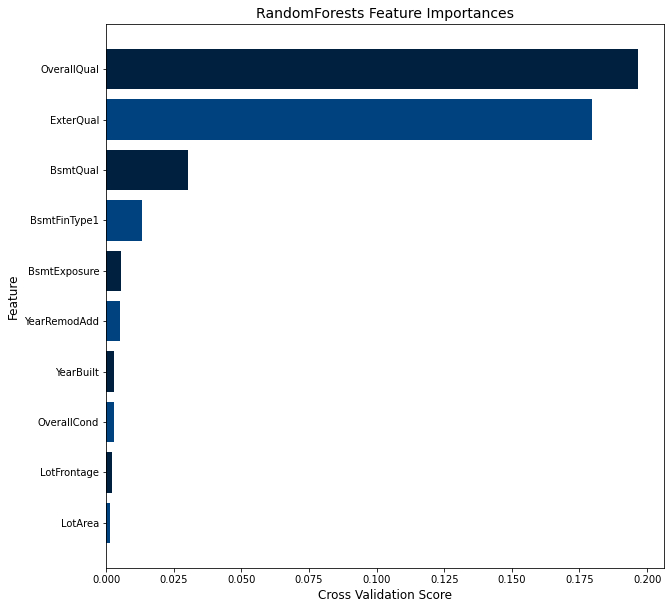

In [255]:
#plotting features importances for Random Forest RFEcv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from numpy.random import rand

data = [2,1]
fig, ax = plt.subplots(1, 1, figsize=(10,10))
 
# Get a color map
my_cmap = cm.get_cmap('ocean')
 
# Get normalize function (takes data in range [vmin, vmax] -> [0, 1])
my_norm = Normalize(vmin=0, vmax=4)
 
ax.barh(sortedfeatureimportances3['Name'], sortedfeatureimportances3['Feature Importance'], color=my_cmap(my_norm(data)))
ax.set_xlabel("Cross Validation Score", fontsize = 12)
ax.set_ylabel("Feature", fontsize = 12)
ax.set_title("RandomForests Feature Importances", fontsize = 14)
plt.show()

In [69]:
#finding the best x features to include using the RFEcv method
gbr4 = GradientBoostingRegressor()
rfecv = RFECV(estimator=gbr4, n_jobs = -1, step=1, scoring = 'neg_mean_squared_error' ,cv=3)
rfecv.fit(df2train, target)

select_features_rfecv = rfecv.get_support()
select_features_rfecv
RFEcv = df2train.loc[:,select_features_rfecv]
print('{:d} Features Select by RFEcv:\n{:}'.format(rfecv.n_features_, RFEcv.columns))

210 Features Select by RFEcv:
Index(['LotFrontage', 'LotArea', 'Alley', 'LotShape', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual',
       ...
       'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New',
       'SaleType_Oth', 'SaleType_WD', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal'],
      dtype='object', length=210)


In [70]:
#finding the best x features using RFEcv with our Lasso 
lasso1 = Lasso()
rfecv3 = RFECV(estimator=lasso1, n_jobs = -1, step=1, scoring = 'neg_mean_squared_error' ,cv=3)
rfecv3.fit(df2train, target)

select_features_rfecv3 = rfecv3.get_support()
RFEcv3 = df2train.loc[:,select_features_rfecv3]
print('{:d} Features Select by RFEcv:\n{:}'.format(rfecv3.n_features_, RFEcv3.columns))

/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348930160112.8071, tolerance: 920372703.0182943
  positive)
/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348930160112.8071, tolerance: 920372703.0182943
  positive)


222 Features Select by RFEcv:
Index(['LotFrontage', 'LotArea', 'Alley', 'LotShape', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=222)


/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348930160112.8071, tolerance: 920372703.0182943
  positive)


In [71]:
#finding the best x features using RFEcv with our Ridge 
ridge1 = Ridge()
rfecv4 = RFECV(estimator=ridge1, n_jobs = -1, step=1, scoring = 'neg_mean_squared_error' ,cv=3)
rfecv4.fit(df2train, target)

select_features_rfecv4 = rfecv4.get_support()
RFEcv4 = df2train.loc[:,select_features_rfecv4]
print('{:d} Features Select by RFEcv:\n{:}'.format(rfecv4.n_features_, RFEcv4.columns))

211 Features Select by RFEcv:
Index(['LotFrontage', 'LotArea', 'Alley', 'LotShape', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=211)


In [72]:
#finding the best x features using RFEcv for XGBoost with our tuned XGB Regressor
xgb4 = XGBRegressor(learning_rate = 0.1, max_depth = 3, n_estimators = 180)
rfecv1 = RFECV(estimator=xgb4, n_jobs = -1, step=1, scoring = 'neg_mean_squared_error' ,cv=3)
rfecv1.fit(df2train, target)

select_features_rfecv1 = rfecv1.get_support()
RFEcv1 = df2train.loc[:,select_features_rfecv1]
print('{:d} Features Select by RFEcv:\n{:}'.format(rfecv1.n_features_, RFEcv1.columns))

46 Features Select by RFEcv:
Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'TotalBsmtSF', 'CentralAir', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars',
       'GarageQual', 'WoodDeckSF', 'OpenPorchSF', 'ScreenPorch', 'TotalArea',
       'Age', 'RecentRemodel', 'YearsSinceRemodel', 'Area1st2nd',
       'MSSubClass_30', 'MSSubClass_60', 'MSZoning_RL', 'MSZoning_RM',
       'Neighborhood_Crawfor', 'Neighborhood_OldTown', 'Neighborhood_StoneBr',
       'Exterior1st_BrkFace', 'GarageType_Attchd', 'MoSold_2', 'SaleType_New',
       'SaleCondition_Family', 'SaleCondition_Normal'],
      dtype='object')


In [ ]:
#creating dataframe of our XGBoost feature importances 
sortedfeatureimportances = np.concatenate((rfecv1.estimator_.feature_importances_[:10].reshape(-1,1), np.array(RFEcv1.columns[:10]).reshape(-1,1)), axis = 1)
sortedfeatureimportances1 = pd.DataFrame(sortedfeatureimportances, columns = ['Feature Importance','Name'])                           
sortedfeatureimportances1 = sortedfeatureimportances1.sort_values(by = 'Feature Importance', ascending = True)                                                                                 
                                        

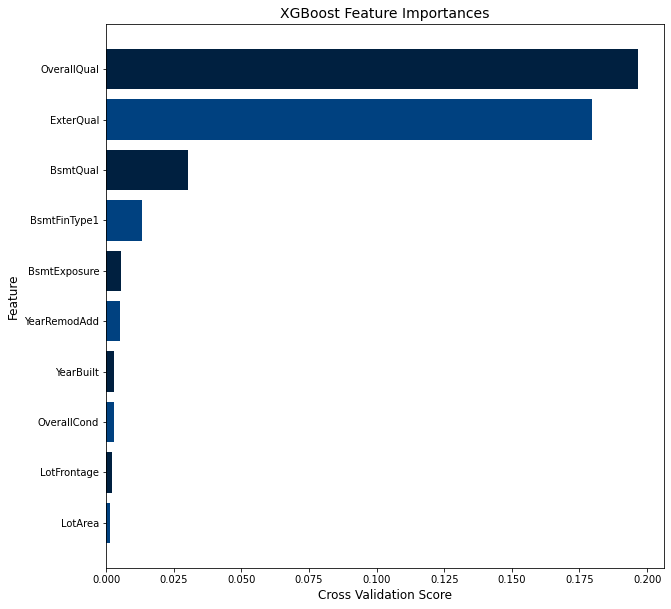

In [270]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from numpy.random import rand

data = [2,1]
fig, ax = plt.subplots(1, 1, figsize=(10,10))
 
# Get a color map
my_cmap = cm.get_cmap('ocean')
 
# Get normalize function (takes data in range [vmin, vmax] -> [0, 1])
my_norm = Normalize(vmin=0, vmax=4)
 
ax.barh(sortedfeatureimportances1['Name'], sortedfeatureimportances1['Feature Importance'], color=my_cmap(my_norm(data)))
ax.set_xlabel("Cross Validation Score", fontsize = 12)
ax.set_ylabel("Feature", fontsize = 12)
ax.set_title("XGBoost Feature Importances", fontsize = 14)
plt.show()

In [206]:
#looking at the RMSE for each feature selection
#RFEcv = GradientBoosting
#RFEcv1 = XGBoost
#RFEcv2 = RandomForest
#RFEcv3 = Lasso
#RFEcv4 = Ridge
resultsdict = {}
#GradientBoosting
score = np.mean(cross_val_score(grid_search_gbr.best_estimator_, df2train.loc[:,select_features_rfecv], target, cv=3, scoring = 'neg_mean_squared_error'))
resultsdict['GBR'] = score 

#XGBoost
score1 = np.mean(cross_val_score(grid_search_xgb.best_estimator_, df2train.loc[:,select_features_rfecv1], target, cv=3, scoring = 'neg_mean_squared_error'))
resultsdict['XGB'] = score1

#RandomForests
score2 = np.mean(cross_val_score(grid_search_rf.best_estimator_, df2train.loc[:,select_features_rfecv2], target, cv=3, scoring = 'neg_mean_squared_error'))
resultsdict['RF'] = score2

#Lasso
score3 = np.mean(cross_val_score(grid_search_lasso.best_estimator_, df2train.loc[:,select_features_rfecv3], target, cv=3, scoring = 'neg_mean_squared_error'))
resultsdict['Lasso'] = score3

#Ridge
score4 = np.mean(cross_val_score(grid_search_ridge.best_estimator_, df2train.loc[:,select_features_rfecv4], target, cv=3, scoring = 'neg_mean_squared_error'))
resultsdict['Ridge'] = score4


/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 266954013404.83594, tolerance: 623306765.1434141
  positive)
/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 245126139227.1376, tolerance: 590479145.3204185
  positive)
/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 260694999483.8842, tolerance: 626679783.5877521
  positive)


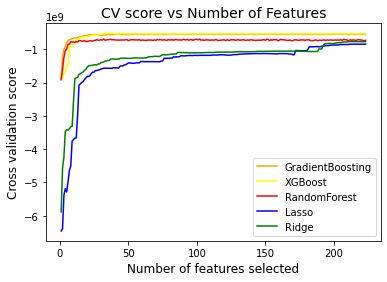

In [203]:
#EDA of feature selection vs RMSE
plt.figure()
plt.title('CV score vs Number of Features', fontsize = 14)
plt.xlabel("Number of features selected", fontsize = 12)
plt.ylabel("Cross validation score", fontsize = 12)
# plt.ylim(-1000000000,-100000000)
plt.xlim()
plt.plot(range(1, len(rfecv3.grid_scores_) + 1), rfecv.grid_scores_, color = 'orange', label = 'GradientBoosting')
plt.plot(range(1, len(rfecv3.grid_scores_) + 1), rfecv1.grid_scores_, color = 'yellow', label = 'XGBoost')
plt.plot(range(1, len(rfecv3.grid_scores_) + 1), rfecv2.grid_scores_, color = 'red', label = 'RandomForest')
plt.plot(range(1, len(rfecv3.grid_scores_) + 1), rfecv3.grid_scores_, color = 'blue', label = 'Lasso')
plt.plot(range(1, len(rfecv4.grid_scores_) + 1), rfecv4.grid_scores_, color = 'green', label = 'Ridge')
plt.legend()
plt.show()

In [107]:
#GridSearchCV for Gradient Boosting
param_grid_gbr = {'learning_rate':np.linspace(0.05,0.5,5), 'min_samples_split':range(3,6), 'max_depth': range(3,6)}
grid_search_gbr = GridSearchCV(gbr99, param_grid_gbr, cv = 3, n_jobs = -1, scoring = 'neg_root_mean_squared_error')
grid_search_gbr.fit(RFEcv, target)
grid_search_gbr.best_params_

{'learning_rate': 0.1625, 'max_depth': 3, 'min_samples_split': 5}

In [108]:
#GridSearchCV for XGBoost
param_grid_xgb = {'max_depth':range(3,5),'learning_rate':np.linspace(0.1,.5,5), 'gamma':range(0,3)}
grid_search_xgb = GridSearchCV(xgb99, param_grid_xgb, cv = 3, n_jobs = -1, scoring = 'neg_root_mean_squared_error')
grid_search_xgb.fit(RFEcv1, target)
grid_search_xgb.best_params_

{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 4}

In [109]:
#GridSearchCV for RandomForest
param_grid_rf = {'max_depth':range(3,6),'min_samples_split':range(2,6), 'n_estimators':range(100,300,100)}
grid_search_rf = GridSearchCV(rf99, param_grid_rf, cv = 3, n_jobs = -1, scoring = 'neg_root_mean_squared_error')
grid_search_rf.fit(RFEcv2, target)
grid_search_rf.best_params_

{'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 200}

In [80]:
#GridSearchCV for Lasso
param_grid_lasso = {'alpha':np.linspace(0.5,100,10)}
grid_search_lasso = GridSearchCV(lasso1, param_grid_ridge, cv = 3, n_jobs = -1, scoring = 'neg_root_mean_squared_error')
grid_search_lasso.fit(RFEcv3, target)
grid_search_lasso.best_params_

/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 412490635734.1092, tolerance: 920372703.0182943
  positive)


{'alpha': 50.0}

In [77]:
#GridSearchCV for Ridge
param_grid_ridge = {'alpha':np.linspace(0.5,50,10)}
grid_search_ridge = GridSearchCV(ridge1, param_grid_ridge, cv = 3, n_jobs = -1, scoring = 'neg_root_mean_squared_error')
grid_search_ridge.fit(RFEcv4, target)
grid_search_ridge.best_params_

{'alpha': 22.5}

In [110]:
#stacking with RFEcv for best feature selection AND hyperparameter 
#RFECv = GradientBoosting
#RFECv1 = XGBoost
#RFEcv2 = RandomForest
#RFECv3 = Lasso
#RFECv4 = Ridge

#Gradient Boosting
grid_search_gbr.best_estimator_.fit(df2train.loc[:,select_features_rfecv], target)
gbr_predictions101 = grid_search_gbr.best_estimator_.predict(df2train.loc[:,select_features_rfecv])
gbr_predictions102 = grid_search_gbr.best_estimator_.predict(df2test.loc[:,select_features_rfecv])

#XGBoost
grid_search_xgb.best_estimator_.fit(df2train.loc[:,select_features_rfecv1], target)
xgb_predictions101 = grid_search_xgb.best_estimator_.predict(df2train.loc[:,select_features_rfecv1])
xgb_predictions102 = grid_search_xgb.best_estimator_.predict(df2test.loc[:,select_features_rfecv1])

#RandomForests
grid_search_rf.best_estimator_.fit(df2train.loc[:,select_features_rfecv2], target)
rf_predictions101 = grid_search_rf.best_estimator_.predict(df2train.loc[:,select_features_rfecv2])
rf_predictions102 = grid_search_rf.best_estimator_.predict(df2test.loc[:,select_features_rfecv2])

#Lasso
grid_search_lasso.best_estimator_.fit(df2train.loc[:,select_features_rfecv3], target)
lasso_predictions101 = grid_search_lasso.best_estimator_.predict(df2train.loc[:,select_features_rfecv3])
lasso_predictions102 = grid_search_lasso.best_estimator_.predict(df2test.loc[:,select_features_rfecv3])

#Ridge
grid_search_ridge.best_estimator_.fit(df2train.loc[:,select_features_rfecv4], target)
ridge_predictions101 = grid_search_ridge.best_estimator_.predict(df2train.loc[:,select_features_rfecv4])
ridge_predictions102 = grid_search_ridge.best_estimator_.predict(df2test.loc[:,select_features_rfecv4])

combined_predictions101 = np.concatenate((gbr_predictions101.reshape(-1,1), xgb_predictions101.reshape(-1,1), rf_predictions101.reshape(-1,1), lasso_predictions101.reshape(-1,1), ridge_predictions101.reshape(-1,1)), axis = 1)
combined_predictions101 = pd.DataFrame(combined_predictions101, columns = ['GBR','XGB','RF','Lasso','Ridge'])

combined_predictions102 = np.concatenate((gbr_predictions102.reshape(-1,1), xgb_predictions102.reshape(-1,1), rf_predictions102.reshape(-1,1), lasso_predictions102.reshape(-1,1), ridge_predictions102.reshape(-1,1)), axis = 1)
combined_predictions102 = pd.DataFrame(combined_predictions102, columns = ['GBR','XGB','RF','Lasso','Ridge'])

x_train101, x_test101, y_train101, y_test101 = train_test_split(combined_predictions101, target, test_size = 0.3)

gbr101 = GradientBoostingRegressor()
gbr101.fit(x_train101, y_train101)
print(gbr101.score(x_train101, y_train101), gbr101.score(x_test101, y_test101))

lm101 = LinearRegression()
lm101.fit(x_train101, y_train101)
print(lm101.score(x_train101, y_train101), lm101.score(x_test101, y_test101))

lasso101 = Lasso()
lasso101.fit(x_train101, y_train101)
print(lasso101.score(x_train101, y_train101), lasso101.score(x_test101, y_test101))


/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 412490635734.1092, tolerance: 920372703.0182943
  positive)


0.99353246005912 0.9869964339449641
0.9898577077643027 0.9888462381755074
0.9898573832611864 0.9888369372088219


/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32721705947.599144, tolerance: 645241088.232479
  positive)


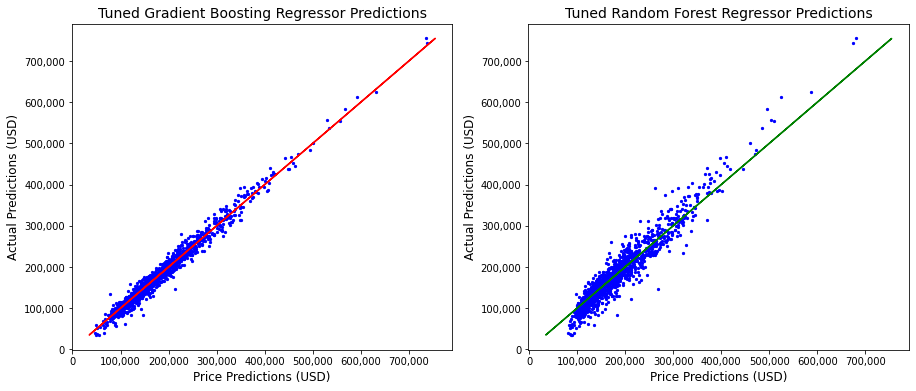

In [209]:
import matplotlib as matplotlib
#Creating EDA for each of these tuned model predictions 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(gbr_predictions101, target, s = 5, c = 'blue')
ax1.plot(target, target, c = 'red')
ax1.set_xlabel('Price Predictions (USD)', fontsize = 12)
ax1.set_ylabel('Actual Predictions (USD)', fontsize = 12)
ax1.set_title('Tuned Gradient Boosting Regressor Predictions', fontsize = 14)
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax2.scatter(rf_predictions101, target, s = 5, c = 'blue')
ax2.plot(target, target, c = 'green')
ax2.set_xlabel('Price Predictions (USD)', fontsize = 12)
ax2.set_ylabel('Actual Predictions (USD)', fontsize = 12)
ax2.set_title('Tuned Random Forest Regressor Predictions', fontsize = 14)
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


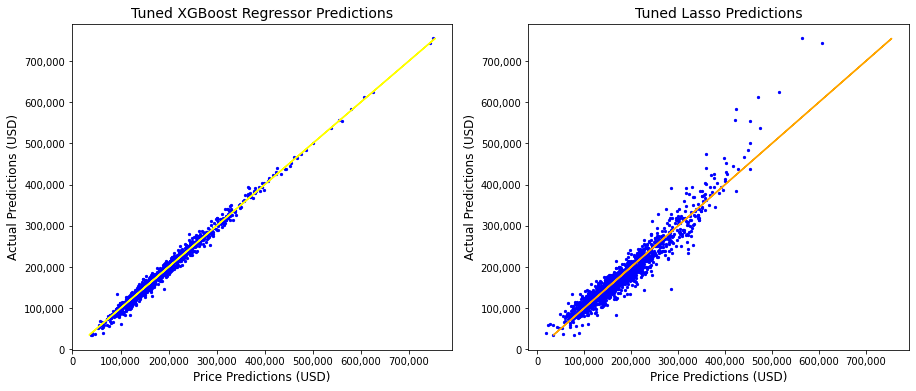

In [210]:
import matplotlib as matplotlib
#Creating EDA for each of these tuned model predictions 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(xgb_predictions101, target, s = 5, c = 'blue')
ax1.plot(target, target, c = 'yellow')
ax1.set_xlabel('Price Predictions (USD)', fontsize = 12)
ax1.set_ylabel('Actual Predictions (USD)', fontsize = 12)
ax1.set_title('Tuned XGBoost Regressor Predictions', fontsize = 14)
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax2.scatter(lasso_predictions101, target, s = 5, c = 'blue')
ax2.plot(target, target, c = 'orange')
ax2.set_xlabel('Price Predictions (USD)', fontsize = 12)
ax2.set_ylabel('Actual Predictions (USD)', fontsize = 12)
ax2.set_title('Tuned Lasso Predictions', fontsize = 14)
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

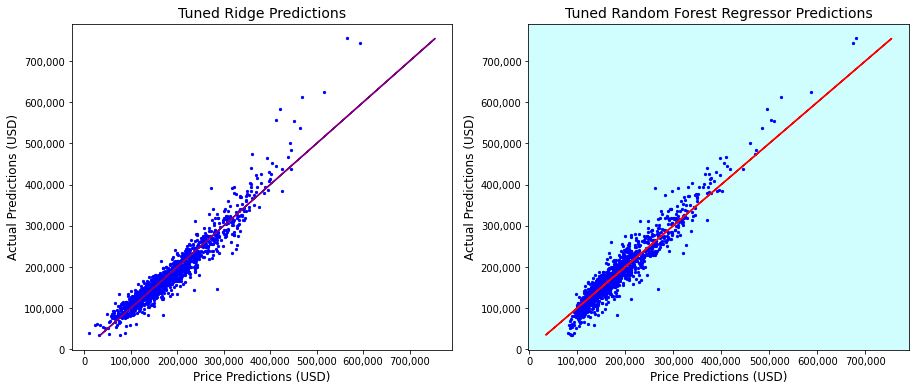

In [211]:
import matplotlib as matplotlib
#Creating EDA for each of these tuned model predictions 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(ridge_predictions101, target, s = 5, c = 'blue')
ax1.plot(target, target, c = 'purple')
ax1.set_xlabel('Price Predictions (USD)', fontsize = 12)
ax1.set_ylabel('Actual Predictions (USD)', fontsize = 12)
ax1.set_title('Tuned Ridge Predictions', fontsize = 14)
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax2.scatter(rf_predictions101, target, s = 5, c = 'blue')
ax2.plot(target, target, c = 'red')
ax2.set_facecolor('xkcd:pale blue')
ax2.set_xlabel('Price Predictions (USD)', fontsize = 12)
ax2.set_ylabel('Actual Predictions (USD)', fontsize = 12)
ax2.set_title('Tuned Random Forest Regressor Predictions', fontsize = 14)
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

In [102]:
#using Gradient Boosting to predict SalePrice using all model predictions
testpredictionsdfgbr = pd.DataFrame(gbr101.predict(combined_predictions102), index = range(1461, 2920), columns = ['SalePrice'])
testpredictionsdfgbr.index.name = 'Id'
testpredictionsdfgbr.to_csv('Kaggle Submission Stacked GBR101.csv')

In [42]:
#stacking with no RFEcv taking place and no hyperparameter tuning taking place

x_train99, x_test99, y_train99, y_test99 = train_test_split(df2train, target, test_size = 0.33)
#GradientBoosting
gbr99 = GradientBoostingRegressor()
gbr99.fit(x_train99, y_train99)
print('GBR scores are:', gbr99.score(x_train99, y_train99), gbr99.score(x_test99, y_test99))
gbr_predictions99 = gbr99.predict(df2train)
gbr_predictions100 = gbr99.predict(df2test)
#XGBoost
xgb99 = XGBRegressor()
xgb99.fit(x_train99, y_train99)
print('XGBoost Scores are:', xgb99.score(x_train99, y_train99), xgb99.score(x_test99, y_test99))
xgb_predictions99 = xgb99.predict(df2train)
xgb_predictions100 = xgb99.predict(df2test)
#RandomForest
rf99 = RandomForestRegressor()
rf99.fit(x_train99, y_train99)
print('Random Forest scores are:', rf99.score(x_train99, y_train99), rf99.score(x_test99, y_test99))
rf_predictions99 = rf99.predict(df2train)
rf_predictions100 = rf99.predict(df2test)
#Lasso
lasso99 = Lasso()
lasso99.fit(x_train99, y_train99)
print('Lasso scores are:', lasso99.score(x_train99, y_train99), lasso99.score(x_test99, y_test99))
lasso_predictions99 = lasso99.predict(df2train)
lasso_predictions100 = lasso99.predict(df2test)
#Ridge
ridge99 = Ridge()
ridge99.fit(x_train99, y_train99)
print('Ridge Forest scores are:', ridge99.score(x_train99, y_train99), ridge99.score(x_test99, y_test99))
ridge_predictions99 = ridge99.predict(df2train)
ridge_predictions100 = ridge99.predict(df2test)



GBR scores are: 0.9765599823796731 0.8902775651531895
XGBoost Scores are: 0.9999189262278557 0.868013827427308
Random Forest scores are: 0.9842575204692082 0.8664778456633779
Lasso scores are: 0.9336026064355643 0.8771992742464486
Ridge Forest scores are: 0.9323029162092257 0.8822127408687488


/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201568917062.23788, tolerance: 600844672.3739702
  positive)


In [43]:
#combining the predictions from no tuning and no feature selection
combined_predictions = np.concatenate((gbr_predictions99.reshape(-1,1), xgb_predictions99.reshape(-1,1), rf_predictions99.reshape(-1,1), lasso_predictions99.reshape(-1,1), ridge_predictions99.reshape(-1,1)), axis = 1)
combined_predictions 
combined_predictions2 = np.concatenate((gbr_predictions100.reshape(-1,1), xgb_predictions100.reshape(-1,1), rf_predictions100.reshape(-1,1), lasso_predictions100.reshape(-1,1), ridge_predictions100.reshape(-1,1)), axis = 1)


In [46]:
#converting combined predictions to DataFrame
combined_predictions = pd.DataFrame(combined_predictions, columns = ['GBR','XGB','RF','Lasso','Ridge'])
combined_predictions

,GBR,XGB,RF,Lasso,Ridge
0,203527.219445,212509.906250,202173.00,196479.643528,197156.013141
1,169808.121817,181071.796875,177150.90,217757.227157,216652.724862
2,218930.275884,224203.421875,220611.01,210194.625001,209314.320961
3,157560.386353,139837.843750,150728.00,163128.059753,164898.153457
4,288404.427174,250298.531250,261970.90,284880.773250,284129.575795
...,...,...,...,...,...
1452,165328.149454,168962.750000,173893.32,161440.766352,160256.832331
1453,196079.227480,209667.312500,209751.86,216448.932299,215329.927393
1454,240873.845868,241259.593750,214788.09,260324.505943,263882.632048
1455,136833.758821,141811.406250,139448.80,156270.234984,155005.322152


In [47]:
#converting combined predictions to DataFrame
combined_predictions2 = pd.DataFrame(combined_predictions2, columns = ['GBR','XGB','RF','Lasso','Ridge'])
combined_predictions2

,GBR,XGB,RF,Lasso,Ridge
0,128801.794208,118498.046875,131966.08,96632.756790,94603.647052
1,173153.235746,149380.468750,159196.80,174517.435264,175413.867372
2,180208.427704,186187.125000,181169.77,172425.147653,171672.948830
3,191817.121000,201803.593750,184413.75,184409.932963,184667.736962
4,203372.683845,212528.765625,203843.50,207610.576541,205831.428651
...,...,...,...,...,...
1454,82468.486394,86776.382812,86783.07,68716.648745,69429.191196
1455,83662.834177,71686.257812,85582.93,63966.397361,59975.187514
1456,166575.154364,162818.703125,162833.50,180817.216908,181510.569202
1457,134720.104869,140641.546875,126010.84,119328.609317,121061.094101


In [48]:
#training a XGBoost algorithm on the combined predictions DataFrame
x_train1, x_test1, y_train1, y_test1 = train_test_split(combined_predictions, target, test_size = 0.3)
xgb5 = XGBRegressor()
xgb5.fit(x_train1, y_train1)
xgb5.score(x_train1, y_train1), xgb5.score(x_test1, y_test1)

(0.9994749841950468, 0.9545136645146957)

In [52]:
#training a Linear Regression algorithm on the combined predictions DataFrame
lm5 = LinearRegression()
lm5.fit(x_train1, y_train1)
lm5.score(x_train1, y_train1), xgb5.score(x_test1, y_test1)

(0.9575580094740684, 0.9545136645146957)

In [50]:
#outputting our XGBoost predictions to a .csv file
testpredictionsdf = pd.DataFrame(xgb5.predict(combined_predictions2), index = range(1461, 2920), columns = ['SalePrice'])
testpredictionsdf.index.name = 'Id'
testpredictionsdf.to_csv('Kaggle Submission Stacked XGBoost100.csv')

In [53]:
#outputting our Linear Regression predictions to a .csv file
testpredictionsdf = pd.DataFrame(lm5.predict(combined_predictions2), index = range(1461, 2920), columns = ['SalePrice'])
testpredictionsdf.index.name = 'Id'
testpredictionsdf.to_csv('Kaggle Submission Stacked LinearRegressor100.csv')

In [54]:
#training a Lasso algorithm on the combined predictions DataFrame
lasso5 = Lasso()
lasso5.fit(x_train1, y_train1)
lasso5.score(x_train1, y_train1), lasso5.score(x_test1, y_test1)

/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 142237340297.1758, tolerance: 670174183.9144506
  positive)


(0.9575519998926384, 0.9663137425605548)

In [56]:
#outputting our Lasso predictions to a .csv file
testpredictionsdf = pd.DataFrame(lasso5.predict(combined_predictions2), index = range(1461, 2920), columns = ['SalePrice'])
testpredictionsdf.index.name = 'Id'
testpredictionsdf.to_csv('Kaggle Submission Stacked Lasso100.csv')

In [57]:
#training a GBR algorithm on the combined predictions DataFrame
gbr5 = GradientBoostingRegressor()
gbr5.fit(x_train1, y_train1)
gbr5.score(x_train1, y_train1), gbr5.score(x_test1, y_test1)

(0.9878411748505658, 0.9670952614278302)

In [58]:
#outputting our GBR predictions to a .csv file
testpredictionsdf = pd.DataFrame(gbr5.predict(combined_predictions2), index = range(1461, 2920), columns = ['SalePrice'])
testpredictionsdf.index.name = 'Id'
testpredictionsdf.to_csv('Kaggle Submission Stacked GBR100.csv')

In [113]:
#taking the mean of all predictions and outputting to a csv file
testpredictionsdfmean102 = pd.DataFrame(np.mean(combined_predictions102, axis = 1).values, index = range(1461, 2920), columns = ['SalePrice'])
testpredictionsdfmean102.index.name = 'Id'
testpredictionsdfmean102.to_csv('Kaggle Submission Mean Stacked Hypertuned2.csv')

In [68]:
testpredictionsdfmean = pd.DataFrame(np.mean(combined_predictions2, axis = 1).values, index = range(1461, 2920), columns = ['SalePrice'])
testpredictionsdfmean.index.name = 'Id'
testpredictionsdfmean.to_csv('Kaggle Submission Mean Stacked.csv')